# Ultrasonic Image Initial Data Analysis and Image Processing

This notebook performs initial data analysis and image processing on ultrasonic images using OpenCV and the `DataProcessorRaw` class. We will explore the relationship between flaw size, labels, and image features across 100 slices per image.

In [24]:
# Import Required Libraries and Classes
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from darkvision.dataset import DataProcessorRaw
from skimage.feature import hog
from skimage import exposure
from skimage.filters import gaussian

# Set up the path to the raw data directory
RAW_DATA_DIR = Path('../data/raw')


In [25]:
# Load a Sample Image and Corresponding Labels
# Choose a sample filename (update as needed)
sample_filename = '59345583-4DB7-44D1-8FDF-11CA79F044B5'
processor = DataProcessorRaw(sample_filename, data_dir=RAW_DATA_DIR)

# Load the 3D image array (shape: 100, 256, 256)
image_stack = processor.load_bin()
labels = processor.load_labels()
data_dict = processor.load_all_data()

# Extract flaw sizes for all slices
flaw_sizes = [data_dict[i]['equivalent_flawsize'] for i in range(image_stack.shape[0])]


2025-06-29 00:19:38.061 | INFO     | darkvision.dataset:load_bin:44 - Loading ..\data\raw\59345583-4DB7-44D1-8FDF-11CA79F044B5.bins
2025-06-29 00:19:38.096 | INFO     | darkvision.dataset:load_bin:49 - Loaded array shape: (100, 256, 256), dtype: uint16
2025-06-29 00:19:38.096 | INFO     | darkvision.dataset:load_labels:73 - Loading ..\data\raw\59345583-4DB7-44D1-8FDF-11CA79F044B5.labels
2025-06-29 00:19:38.096 | INFO     | darkvision.dataset:load_json:56 - Loading ..\data\raw\59345583-4DB7-44D1-8FDF-11CA79F044B5.jsons
2025-06-29 00:19:38.097 | INFO     | darkvision.dataset:load_labels:73 - Loading ..\data\raw\59345583-4DB7-44D1-8FDF-11CA79F044B5.labels
2025-06-29 00:19:38.097 | INFO     | darkvision.dataset:load_all_data:110 - Loaded complete dataset with 100 slices


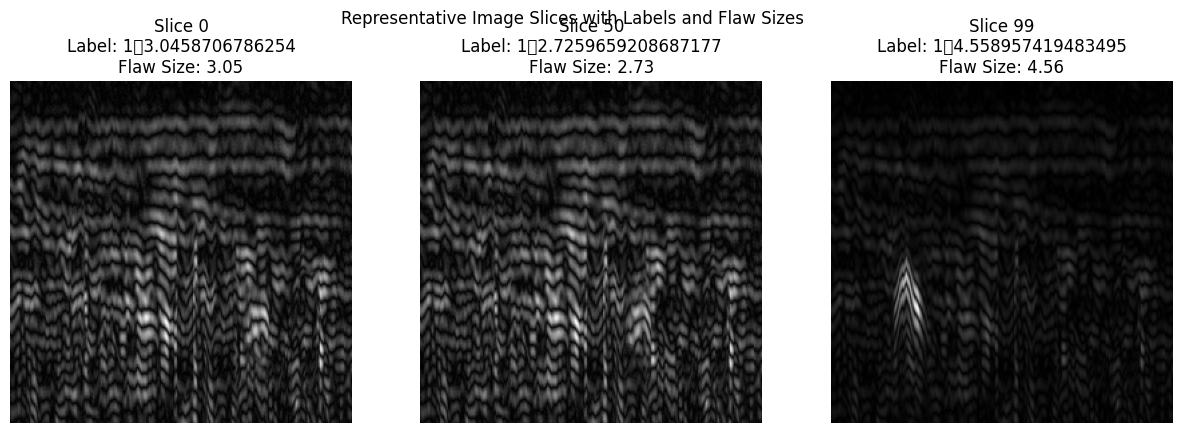

In [26]:
# Visualize Image Slices and Labels
num_slices = image_stack.shape[0]
slices_to_show = [0, num_slices//2, num_slices-1]  # First, middle, last slice

plt.figure(figsize=(15, 5))
for i, idx in enumerate(slices_to_show):
    plt.subplot(1, len(slices_to_show), i+1)
    plt.imshow(image_stack[idx], cmap='gray')
    plt.title(f"Slice {idx}\nLabel: {labels[idx]}\nFlaw Size: {flaw_sizes[idx]:.2f}")
    plt.axis('off')
plt.suptitle('Representative Image Slices with Labels and Flaw Sizes')
plt.show()

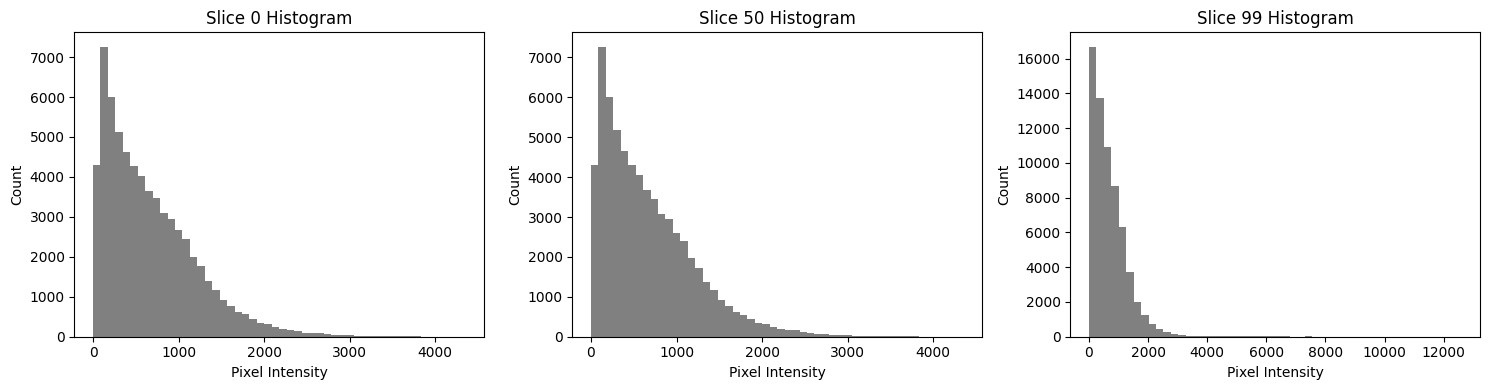

In [27]:
# Basic Image Statistics and Histogram Analysis
slice_stats = []
for idx in range(image_stack.shape[0]):
    img = image_stack[idx]
    stats = {
        'mean': np.mean(img),
        'std': np.std(img),
        'min': np.min(img),
        'max': np.max(img)
    }
    slice_stats.append(stats)

# Plot histograms for selected slices
plt.figure(figsize=(15, 4))
for i, idx in enumerate(slices_to_show):
    plt.subplot(1, len(slices_to_show), i+1)
    plt.hist(image_stack[idx].ravel(), bins=50, color='gray')
    plt.title(f"Slice {idx} Histogram")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [28]:
image_stack

array([[[ 73, 166, 238, ..., 513, 291, 115],
        [ 96, 180, 260, ..., 408, 330,  55],
        [ 46, 112, 273, ..., 369, 266,  44],
        ...,
        [265, 591, 426, ..., 239, 552, 359],
        [142, 363, 334, ...,  51, 359, 190],
        [ 19, 103, 121, ...,  50, 162,  50]],

       [[ 73, 166, 238, ..., 513, 291, 115],
        [ 96, 180, 260, ..., 408, 330,  55],
        [ 46, 112, 273, ..., 369, 266,  44],
        ...,
        [265, 591, 426, ..., 239, 552, 359],
        [142, 363, 334, ...,  51, 359, 190],
        [ 19, 103, 121, ...,  50, 162,  50]],

       [[ 73, 166, 238, ..., 513, 291, 115],
        [ 96, 180, 260, ..., 408, 330,  55],
        [ 46, 112, 273, ..., 369, 266,  44],
        ...,
        [265, 591, 426, ..., 239, 552, 359],
        [142, 363, 334, ...,  51, 359, 190],
        [ 19, 103, 121, ...,  50, 162,  50]],

       ...,

       [[115, 291, 513, ..., 238, 166,  73],
        [ 55, 330, 408, ..., 260, 180,  96],
        [ 44, 266, 369, ..., 273, 112,  46

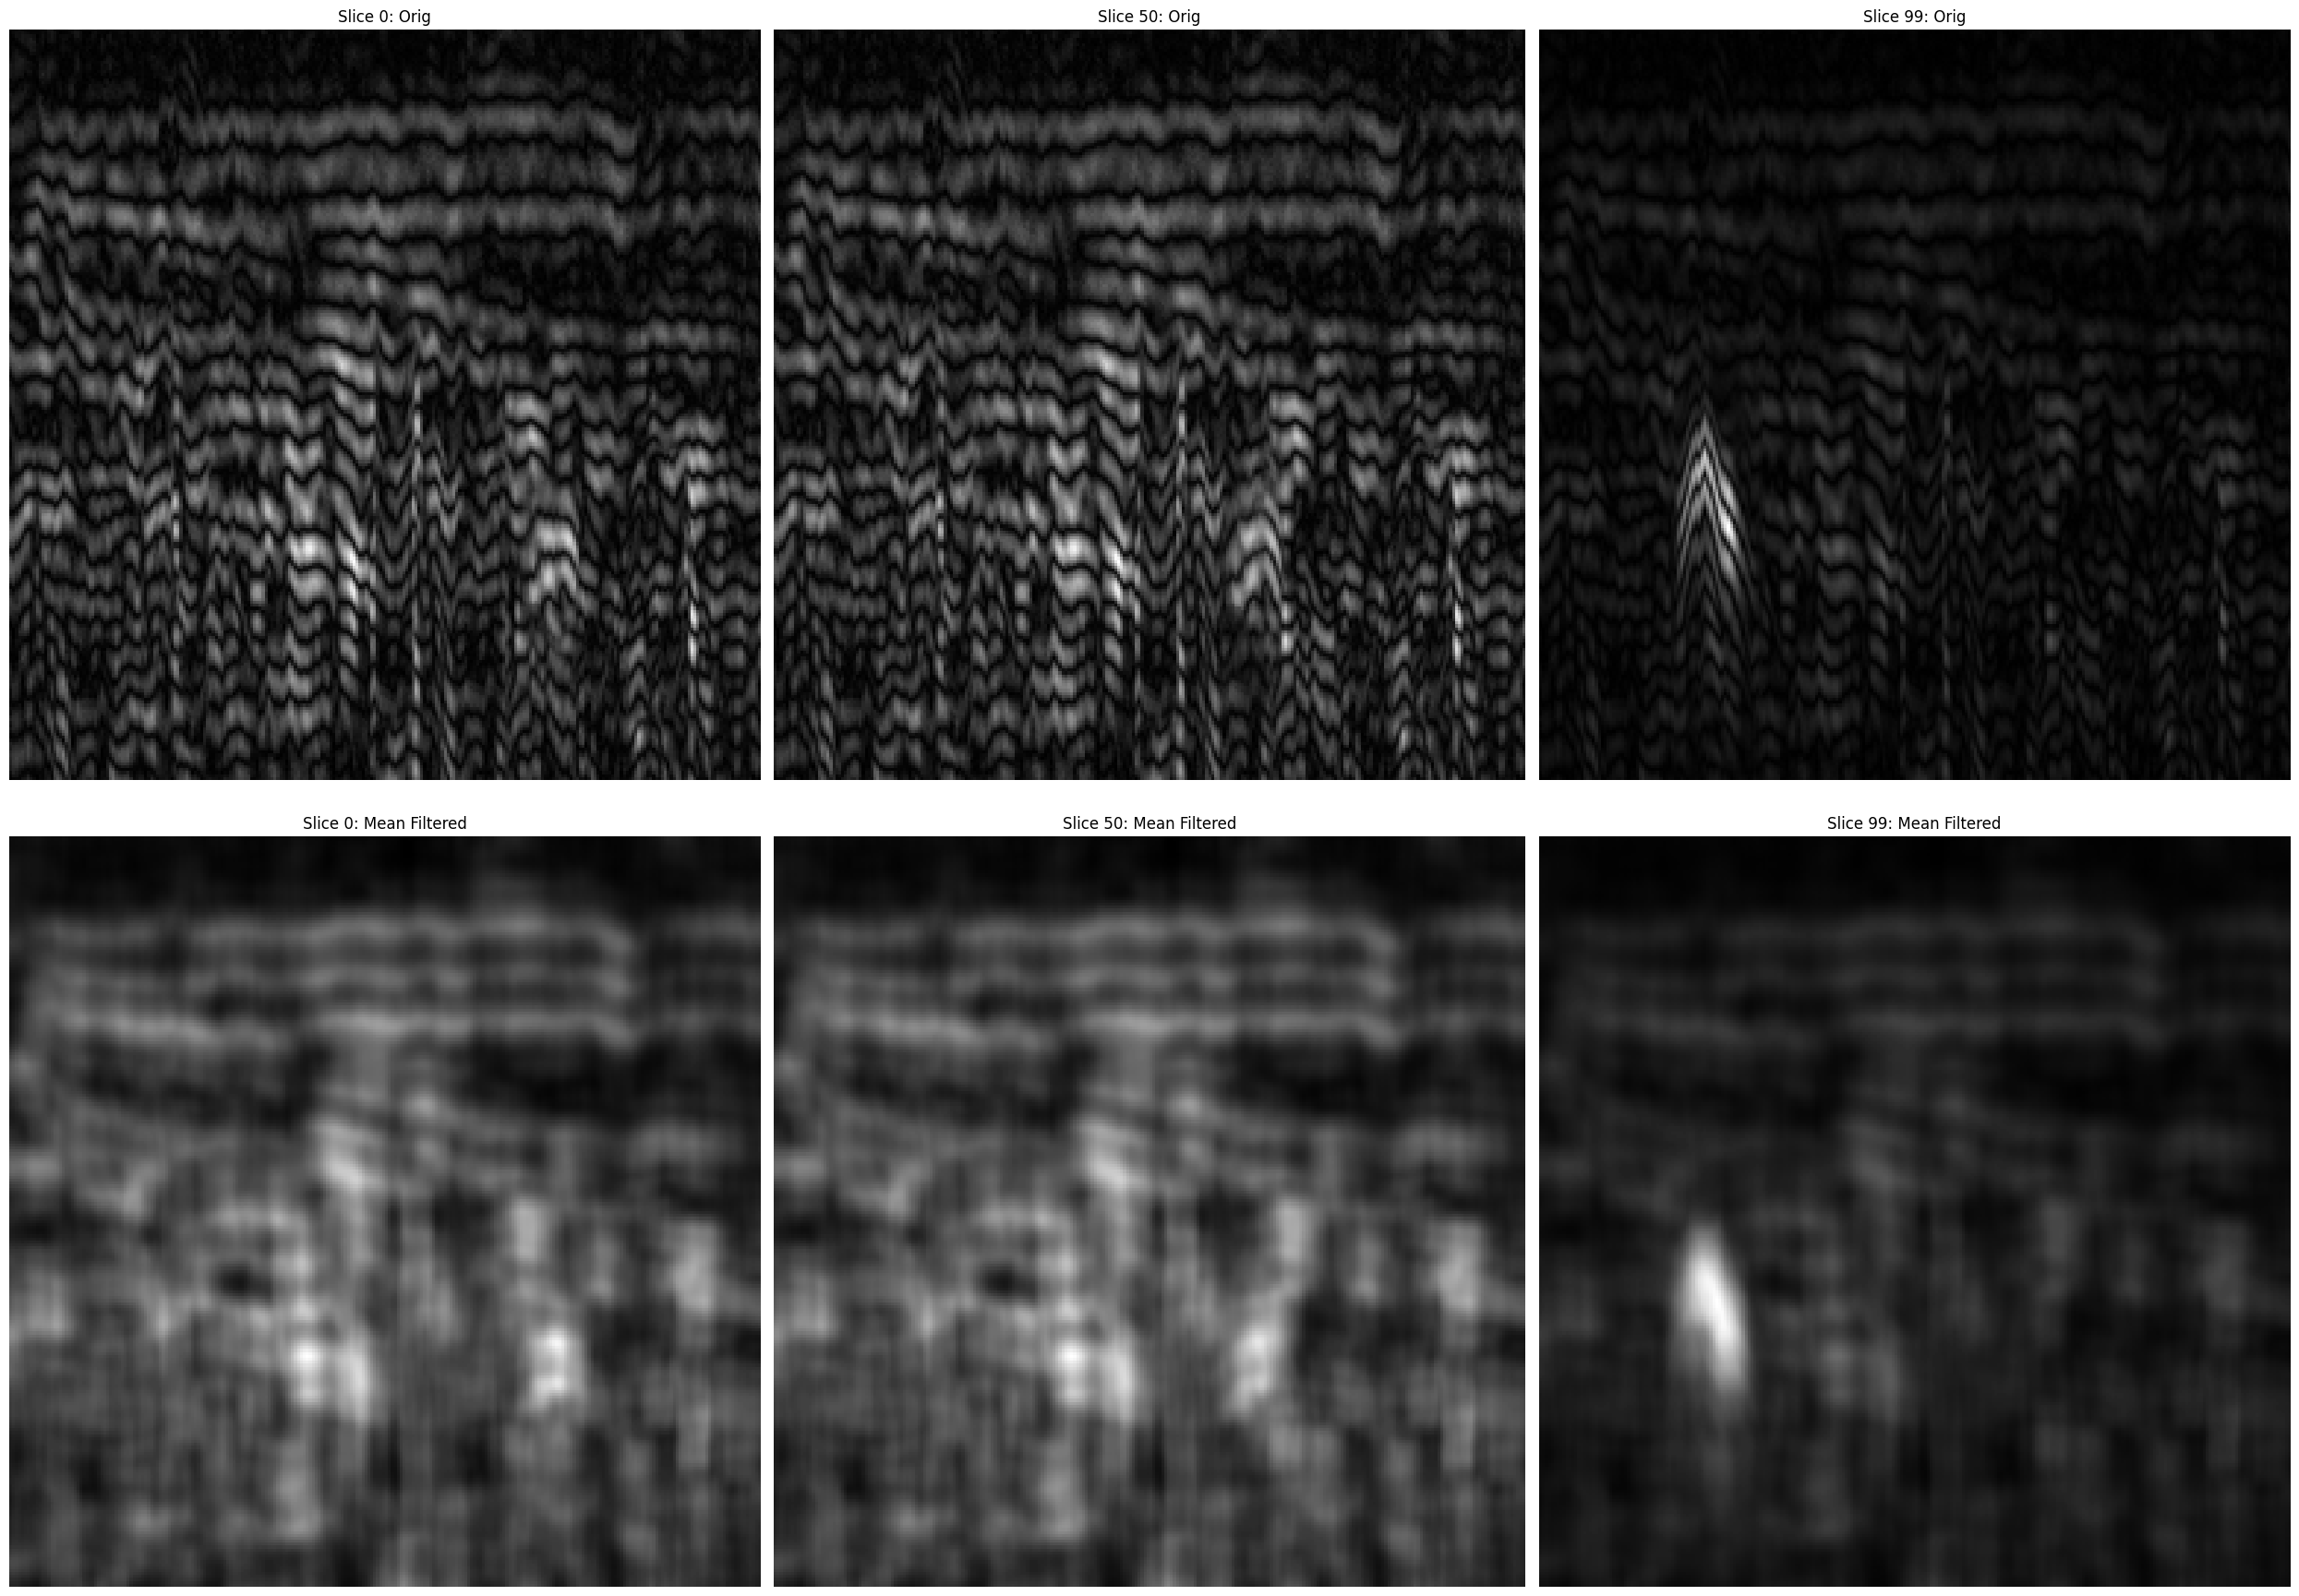

In [29]:
# 1) Mean (box) filtering
from scipy.ndimage import uniform_filter

cv2_slices = [image_stack[idx] for idx in slices_to_show]

plt.figure(figsize=(25, 18))
for i, img in enumerate(cv2_slices):
    # normalize
    img_norm = img.astype(np.float32)
    img_norm -= img_norm.min()
    if img_norm.max() > 0:
        img_norm /= img_norm.max()
    
    # mean filter (e.g. 11×11 window)
    smoothed = uniform_filter(img_norm, size=11)
    
    # display
    plt.subplot(2, len(cv2_slices), i+1)
    plt.imshow(img_norm, cmap='gray')
    plt.title(f'Slice {slices_to_show[i]}: Orig')
    plt.axis('off')
    
    plt.subplot(2, len(cv2_slices), i+1+len(cv2_slices))
    plt.imshow(smoothed, cmap='gray')
    plt.title(f'Slice {slices_to_show[i]}: Mean Filtered')
    plt.axis('off')

plt.tight_layout()


Slice 0: Detected flaw with size (area): 6354.0 pixels


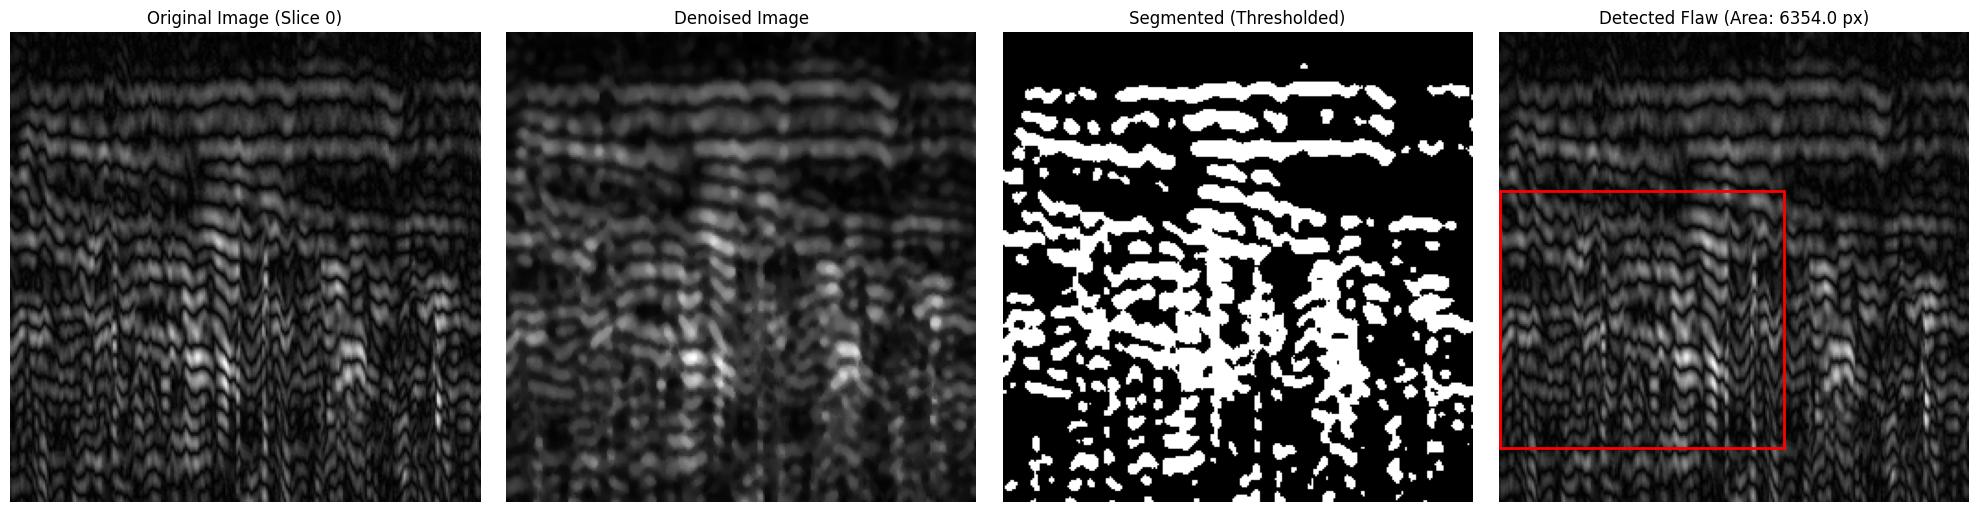

Slice 50: Detected flaw with size (area): 8156.0 pixels


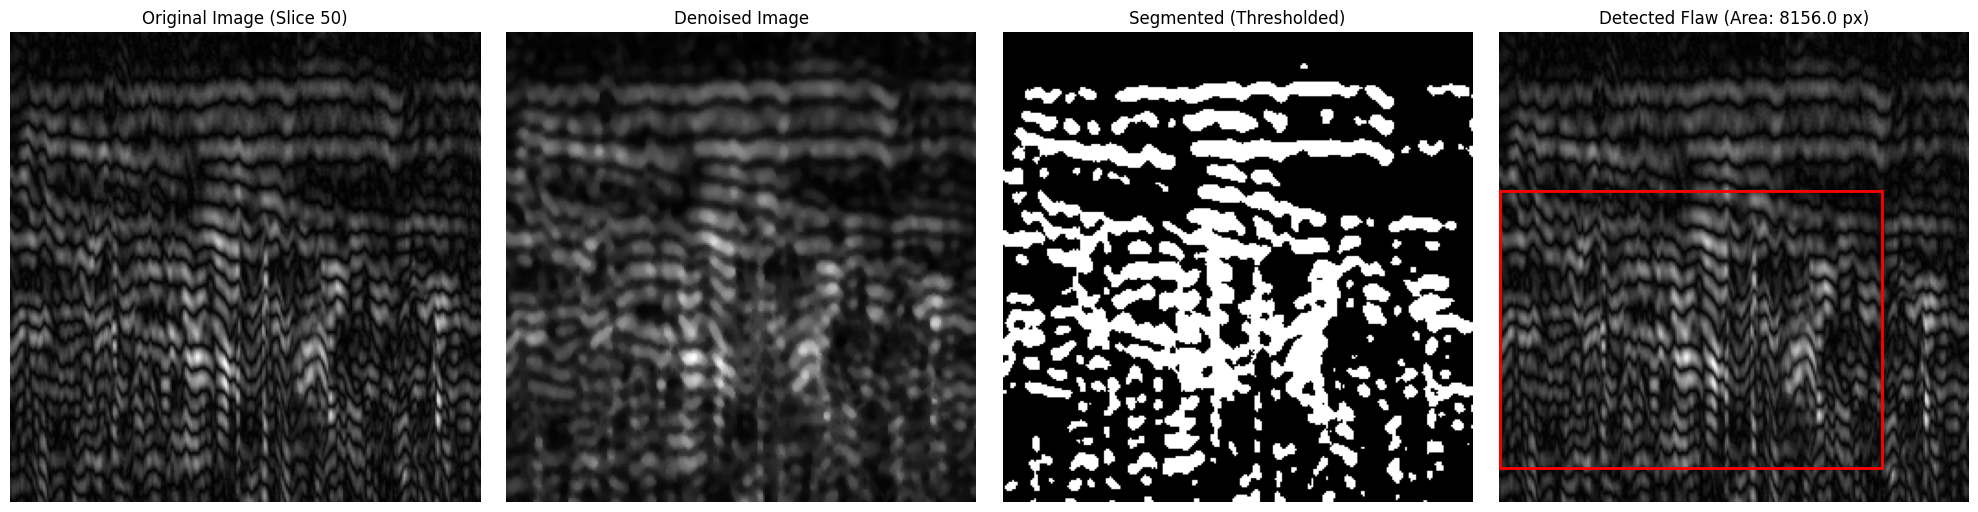

Slice 99: Detected flaw with size (area): 1642.0 pixels


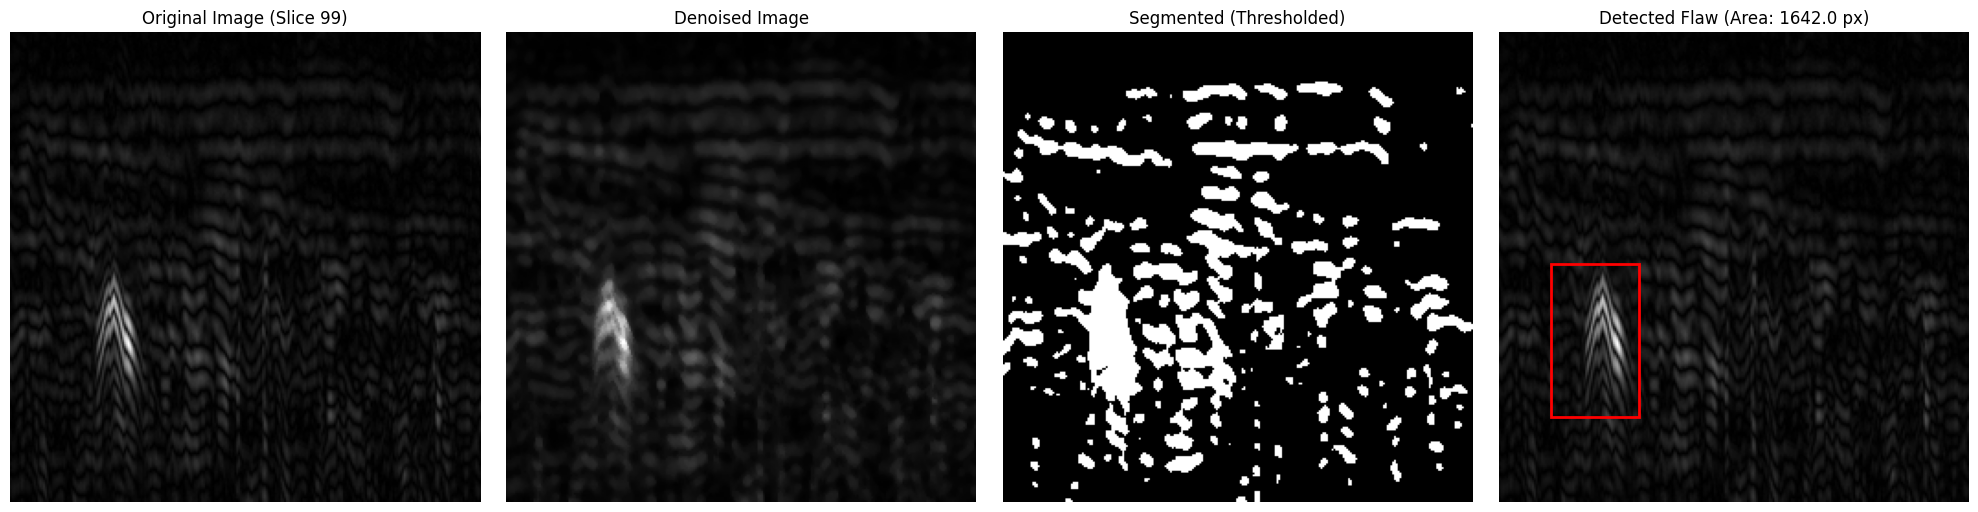

In [30]:
# Integrate flaw detection pipeline for each image in cv2_slices

from skimage import filters, morphology, measure

for i, img in enumerate(cv2_slices):
    # --- Step 1: Denoise the image to remove horizontal lines ---
    denoised_image = filters.median(img, morphology.disk(3))

    # --- Step 2: Identify high-intensity zones using thresholding ---
    thresh = filters.threshold_otsu(denoised_image)
    binary_image = denoised_image > thresh

    # --- Step 3: Detect and measure the flaw ---
    labels_img = measure.label(binary_image)
    min_flaw_area = 50  # Adjust as needed
    regions = measure.regionprops(labels_img)
    flaw_regions = [r for r in regions if r.area > min_flaw_area]

    flaw_area = 0
    main_flaw = None
    if flaw_regions:
        flaw_regions.sort(key=lambda r: r.area, reverse=True)
        main_flaw = flaw_regions[0]
        flaw_area = main_flaw.area
        print(f"Slice {slices_to_show[i]}: Detected flaw with size (area): {flaw_area} pixels")
    else:
        print(f"Slice {slices_to_show[i]}: No flaw detected.")

    # --- Step 4: Visualize the results ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    ax = axes.ravel()

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'Original Image (Slice {slices_to_show[i]})')

    ax[1].imshow(denoised_image, cmap='gray')
    ax[1].set_title('Denoised Image')

    ax[2].imshow(binary_image, cmap='gray')
    ax[2].set_title('Segmented (Thresholded)')

    ax[3].imshow(img, cmap='gray')
    ax[3].set_title(f'Detected Flaw (Area: {flaw_area} px)')
    # Add a bounding box around the detected flaw
    if main_flaw is not None:
        minr, minc, maxr, maxc = main_flaw.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             fill=False, edgecolor='red', linewidth=2)
        ax[3].add_patch(rect)

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

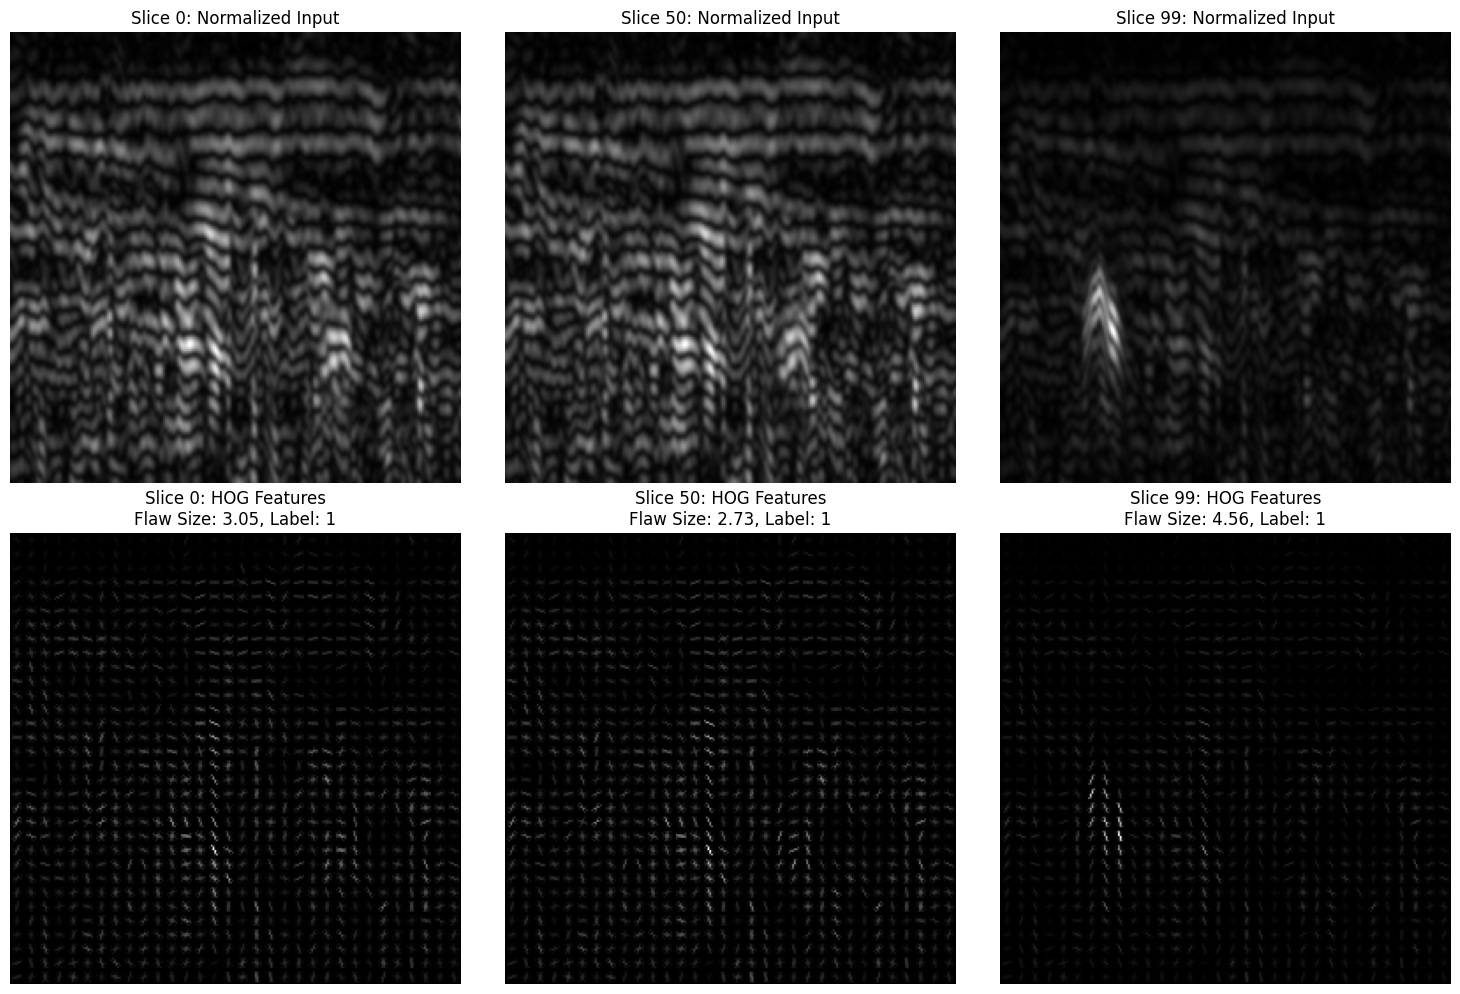

HOG feature vector length: 8192
HOG feature vector shape: (8192,)
HOG parameters: orientations=8, pixels_per_cell=(4,4), cells_per_block=(2,2), block_norm='L2-Hys'


In [31]:



cv2_slices = [image_stack[idx] for idx in slices_to_show]

plt.figure(figsize=(15, 10))
for i, img in enumerate(cv2_slices):
    # — normalize to [0,1] —
    img_norm = img.astype(np.float32)
    img_norm -= img_norm.min()
    if img_norm.max() > 0:
        img_norm /= img_norm.max()

    smoothed = gaussian(
        img_norm,
        sigma=1.0,
        truncate=3.0,
        preserve_range=True
    )


    # Compute HOG features and visualization
    fd, hog_image = hog(
        smoothed,
        orientations=8,            # balanced detail vs robustness
        pixels_per_cell=(8, 8),    # good for medium-resolution features
        cells_per_block=(1, 1),    # provides illumination invariance
        block_norm='L2-Hys',       # most robust normalization
        visualize=True
    )

    # Rescale HOG histogram for better display

    # Add flaw size and label to the image title
    flaw_size = flaw_sizes[slices_to_show[i]]
    label = labels[slices_to_show[i]]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display normalized input image
    plt.subplot(2, len(cv2_slices), i+1)
    plt.imshow(smoothed, cmap='gray')
    plt.title(f'Slice {slices_to_show[i]}: Normalized Input')
    plt.axis('off')

    # Display HOG visualization
    plt.subplot(2, len(cv2_slices), i+1+len(cv2_slices))
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title(f'Slice {slices_to_show[i]}: HOG Features\nFlaw Size: {flaw_size:.2f}, Label: {label[0]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print HOG feature information for the first slice
if cv2_slices:
    print(f"HOG feature vector length: {len(fd)}")
    print(f"HOG feature vector shape: {fd.shape}")
    print("HOG parameters: orientations=8, pixels_per_cell=(4,4), cells_per_block=(2,2), block_norm='L2-Hys'")


In [32]:
# Analyze Relationship Between Flaw Size and Image Features
mean_intensities = [np.mean(image_stack[i]) for i in range(image_stack.shape[0])]
edge_counts = []
for i in range(image_stack.shape[0]):
    img = image_stack[i].astype(np.uint8)
    edges = cv2.Canny(img, 50, 150)
    edge_counts.append(np.sum(edges > 0))

# Prepare flaw sizes (already loaded)
flaw_sizes_arr = np.array(flaw_sizes)


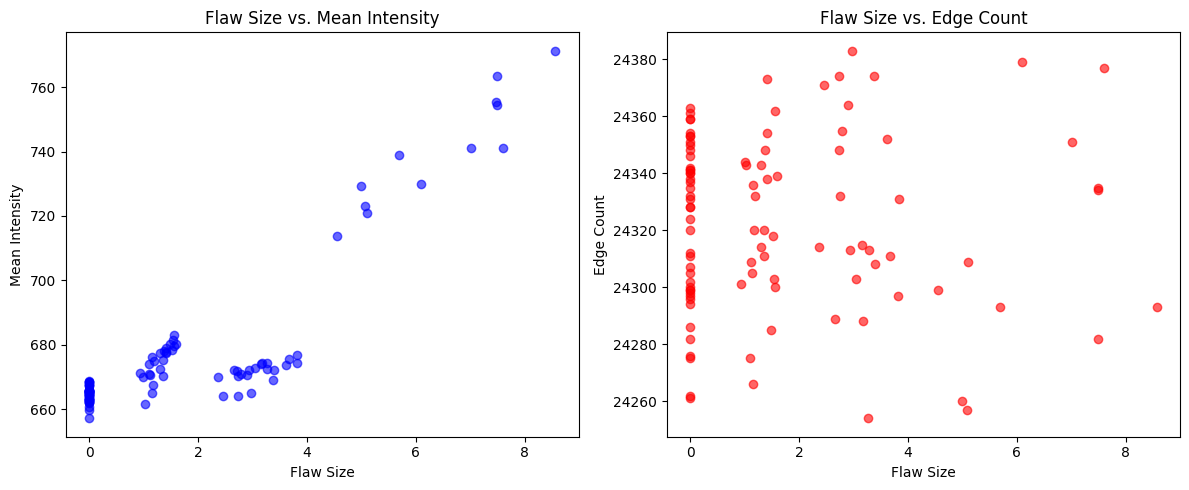

In [33]:
# Plot Flaw Size vs. Image Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(flaw_sizes_arr, mean_intensities, c='blue', alpha=0.6)
plt.xlabel('Flaw Size')
plt.ylabel('Mean Intensity')
plt.title('Flaw Size vs. Mean Intensity')

plt.subplot(1, 2, 2)
plt.scatter(flaw_sizes_arr, edge_counts, c='red', alpha=0.6)
plt.xlabel('Flaw Size')
plt.ylabel('Edge Count')
plt.title('Flaw Size vs. Edge Count')
plt.tight_layout()
plt.show()

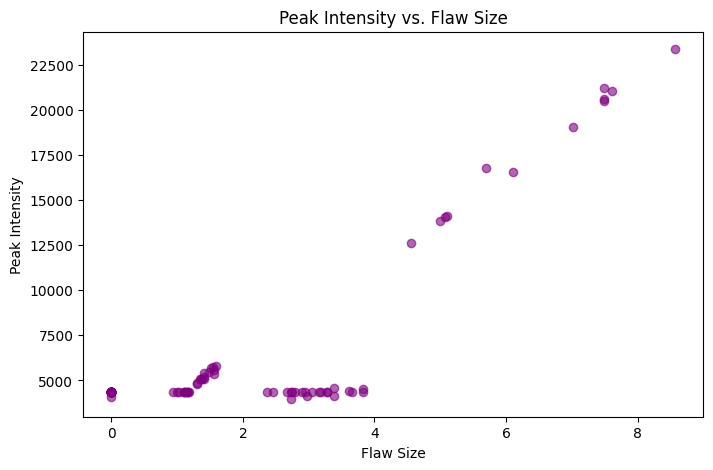

In [34]:
# Compute peak (maximum) intensity for each slice
peak_intensities = [np.max(image_stack[i]) for i in range(image_stack.shape[0])]

# Plot peak intensity vs. flaw size
plt.figure(figsize=(8, 5))
plt.scatter(flaw_sizes, peak_intensities, c='purple', alpha=0.6)
plt.xlabel('Flaw Size')
plt.ylabel('Peak Intensity')
plt.title('Peak Intensity vs. Flaw Size')
plt.show()